In [3]:
import sys
sys.path.insert(0,'/home/djl34/kl_git/scripts')
from notebook_imports import *

In [17]:
import scipy.stats as stats
import matplotlib.pyplot as plt
from copy import deepcopy
import rpy2

## Import some R functions for calculating confidence intervales of Poisson ratios

from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector
exactci = importr("exactci")

def calc_95_CI(X1, X2, N1, N2):
    CI = exactci.poisson_exact(FloatVector([X1, X2]), FloatVector([N1, N2]))
    return float(CI[4][0]), list(CI[3])

def calc_95_CI_single(X1, N1):
    CI = exactci.poisson_exact(float(X1), float(N1))
    return float(CI[4][0]), list(CI[3])

def add_estimates(data_mut):
    nbins = data_mut.shape[0]
    total_sites = data_mut.number_of_sites_no_SNV + data_mut.number_of_sites_SNV
    total_muts = data_mut.number_of_mutations_no_SNV + data_mut.number_of_mutations_SNV
    data_mut["total_sites"] = total_sites
    data_mut["total_muts"] = total_muts
    
    mu_ests, mu_upper_CI, mu_lower_CI = np.zeros(nbins), np.zeros(nbins), np.zeros(nbins)
    ratio_ests, ratio_upper_CI, ratio_lower_CI = np.zeros(nbins), np.zeros(nbins), np.zeros(nbins)
    for ii in range(nbins):
        mu_est = calc_95_CI_single(total_muts[ii], total_sites[ii])
        mu_ests[ii] = mu_est[0]
        mu_lower_CI[ii] = mu_est[1][0]
        mu_upper_CI[ii] = mu_est[1][1]
        
        ratio_est = calc_95_CI(data_mut.number_of_mutations_SNV[ii], data_mut.number_of_mutations_no_SNV[ii], 
                               data_mut.number_of_sites_SNV[ii], data_mut.number_of_sites_no_SNV[ii])
        ratio_ests[ii] = ratio_est[0]
        ratio_lower_CI[ii] = ratio_est[1][0]
        ratio_upper_CI[ii] = ratio_est[1][1]
        
        
    data_mut["mu_est"] = mu_ests
    data_mut["mu_95CI_lower"] = mu_lower_CI
    data_mut["mu_95CI_upper"] = mu_upper_CI
    
    data_mut["ratio_est"] = ratio_ests
    data_mut["ratio_95CI_lower"] = ratio_lower_CI
    data_mut["ratio_95CI_upper"] = ratio_upper_CI
    
    data_mut["prop_poly"] = data_mut.number_of_sites_SNV / data_mut.total_sites

def plot_ratios(data_mut, ax, mu_scale, color="black", alpha=0.8, alpha_ebar=0.3, label=None):
    ax.scatter(data_mut.mu*mu_scale, data_mut.ratio_est, color=color, alpha=alpha, label=label)
    ax.errorbar(data_mut.mu*mu_scale, data_mut.ratio_est, 
                yerr=[data_mut.ratio_est - data_mut.ratio_95CI_lower, 
                      data_mut.ratio_95CI_upper - data_mut.ratio_est], fmt="none", color=color, alpha=alpha_ebar)


def plot_mu_ratios(data_mut, ax, mu_scale, color="black", alpha=0.8, alpha_ebar=0.3, label=None):
    ax.scatter(data_mut.mu_est*mu_scale, data_mut.ratio_est, color=color, alpha=alpha, label=label)
    ax.errorbar(data_mut.mu_est*mu_scale, data_mut.ratio_est, 
                yerr=[data_mut.ratio_est - data_mut.ratio_95CI_lower, 
                      data_mut.ratio_95CI_upper - data_mut.ratio_est], fmt="none", color=color, alpha=alpha_ebar)
    ax.errorbar(data_mut.mu_est*mu_scale, data_mut.ratio_est, 
                xerr=[data_mut.mu_est*mu_scale - data_mut.mu_95CI_lower*mu_scale, 
                      data_mut.mu_95CI_upper*mu_scale - data_mut.mu_est*mu_scale], fmt="none", color=color, alpha=alpha_ebar)

In [2]:
client = Client()

In [3]:
filename = os.path.join(KL_data_dir, "results/method_validation/footprints/zoonomia/{chrom}.tsv")

ddf = dd.read_csv([filename.format(chrom = chrom) for chrom in all_chrom_set], sep = "\t", dtype={'Spliceai_info': 'object', 'DHS_tissue': 'object', 'footprint_motif_clusters': 'object'},
                  usecols=['mu', 'AC_total', 'denovo_an_case', 'denovo_an_control', 'denovo_halldorsson_control'])
ddf = ddf.fillna(0)
# df = ddf.compute()

In [6]:
len(ddf)

176923101

# 1. First try grouping all of the sites together

Ratio of observed SNV / non SNV sites for *de novo* mutations seem to be around 1.25. This doesn't seem crazy high to me

In [41]:
polymorphic_sum

mu                            6283649.441
denovo_an_case                   1578.000
denovo_an_control                1526.000
denovo_halldorsson_control       2212.000
dtype: float64

In [11]:
polymorphic_sum = ddf[ddf["polymorphic"]][columns].sum().compute()
monomorphic_sum = ddf[~ddf["polymorphic"]][columns].sum().compute()

In [37]:
sum = pd.DataFrame(polymorphic_sum/polymorphic_sum["mu"])
sum.rename({0: "polymorphic"}, axis = 1, inplace = True)

In [38]:
sum["monomorphic"] = monomorphic_sum/monomorphic_sum["mu"]

In [13]:
sum

<function sum(iterable, /, start=0)>

In [39]:
sum.reset_index(inplace = True)

In [42]:
sum["polymorphic"]/sum["monomorphic"]

0    1.000000
1    1.266794
2    1.271278
3    1.224662
dtype: float64

# 2. Let's try grouping by mutation rate

I can't tell that there is crazy amounts of mutation rate misspecification in the TF Footprints

In [5]:
filename = os.path.join(KL_data_dir, "results/method_validation/footprints/residual_variance_AC_0.tsv")
filename1 = os.path.join(KL_data_dir, "results/method_validation/footprints/residual_variance_AC_1.tsv")
filename2 = os.path.join(KL_data_dir, "results/method_validation/footprints/residual_variance_AC_2.tsv")
filename3 = os.path.join(KL_data_dir, "results/method_validation/footprints/residual_variance_AC_3.tsv")

In [6]:
sum = pd.read_csv(filename, sep = "\t")
sum1 = pd.read_csv(filename1, sep = "\t")
sum2 = pd.read_csv(filename2, sep = "\t")
sum3 = pd.read_csv(filename3, sep = "\t")

In [11]:
add_estimates(sum)
add_estimates(sum1)
add_estimates(sum2)
add_estimates(sum3)

In [12]:
mu_vals = sum["mu"] * per_generation_factor

In [13]:
import scipy.optimize as optim
optim.curve_fit(lambda A, mu_est : A*mu_est, mu_vals, sum.mu_est, 1e6)

(array([7658.87660321]), array([[10556.97651999]]))

In [17]:
sample_size = 1902*2 + 2976
mu_scale = 1/7658.87660321

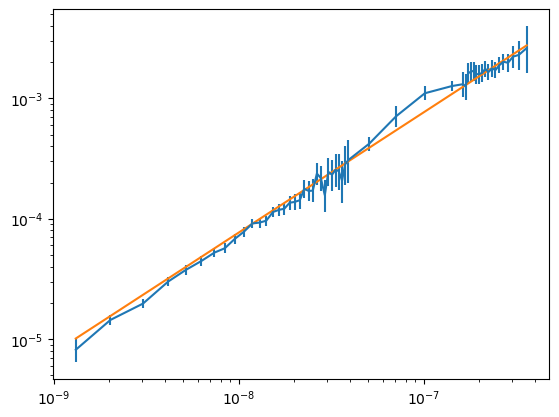

In [44]:
plt.errorbar(mu_vals, sum.mu_est, 
             yerr=[sum.mu_est - sum.mu_95CI_lower, 
                   sum.mu_95CI_upper - sum.mu_est])
plt.plot(mu_vals, mu_vals/mu_scale)
plt.yscale("log")
plt.xscale("log")

In [21]:
from matplotlib import cm
c_sum = cm.get_cmap("tab10")(0)
c_sum1 = cm.get_cmap("tab10")(1)
c_sum2 = cm.get_cmap("tab10")(2)
c_sum3 = cm.get_cmap("tab10")(3)

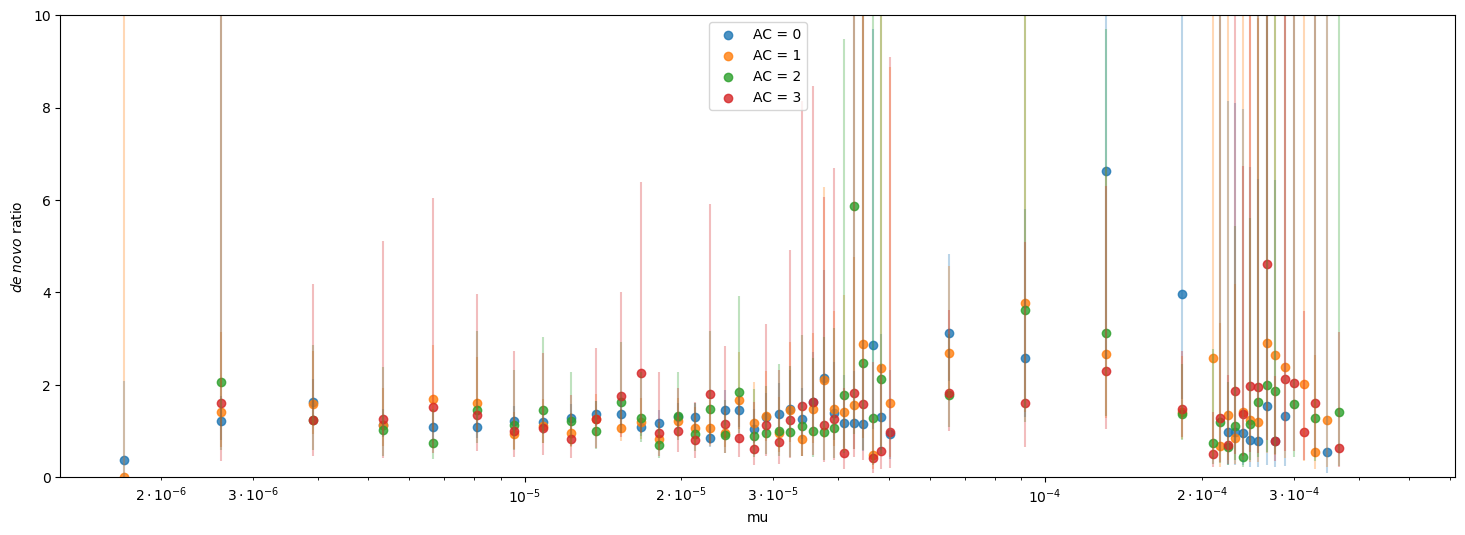

In [24]:
fig, ax = plt.subplots(figsize=(18, 6))
plot_ratios(sum, ax, alpha=0.8, color=c_sum, label="AC = 0")
plot_ratios(sum1, ax, alpha=0.8, color=c_sum1, label="AC = 1")
plot_ratios(sum2, ax, alpha=0.8, color=c_sum2, label="AC = 2")
plot_ratios(sum3, ax, alpha=0.8, color=c_sum3, label="AC = 3")

ax.set_xscale("logit")
ax.set_ylim([0,10])
ax.set_ylabel(r"$\it{de {}_ novo}$ ratio")
ax.set_xlabel("mu")
ax.legend(loc="upper center")

# 3. Let's try splitting the footprints into top and bottom half

Mutation rate misspecification is playing a role in KL ranking for TF Footprints.

In [6]:
filename2_1 = os.path.join(KL_data_dir, "results/residual_variance/footprints/KL_2_split_1_half_AC_0.tsv")
filename2_2 = os.path.join(KL_data_dir, "results/residual_variance/footprints/KL_2_split_2_half_AC_0.tsv")
filename7_1 = os.path.join(KL_data_dir, "results/residual_variance/footprints/KL_9_split_1_half_AC_0.tsv")
filename7_2 = os.path.join(KL_data_dir, "results/residual_variance/footprints/KL_9_split_2_half_AC_0.tsv")

In [7]:
sum = pd.read_csv(filename2_1, sep = "\t")
sum1 = pd.read_csv(filename2_2, sep = "\t")
sum2 = pd.read_csv(filename7_1, sep = "\t")
sum3 = pd.read_csv(filename7_2, sep = "\t")

In [8]:
add_estimates(sum)
add_estimates(sum1)
add_estimates(sum2)
add_estimates(sum3)

In [10]:
mu_vals = sum["mu"] * per_generation_factor

import scipy.optimize as optim
optim.curve_fit(lambda A, mu_est : A*mu_est, mu_vals, sum.mu_est, 1e6)

(array([7999.10278935]), array([[20946.73301274]]))

In [11]:
mu_scale = 1/7999.10278935

In [13]:
from matplotlib import cm
c_sum = cm.get_cmap("tab10")(0)
c_sum1 = cm.get_cmap("tab10")(1)
# c_sum2 = cm.get_cmap("tab10")(2)
# c_sum3 = cm.get_cmap("tab10")(3)

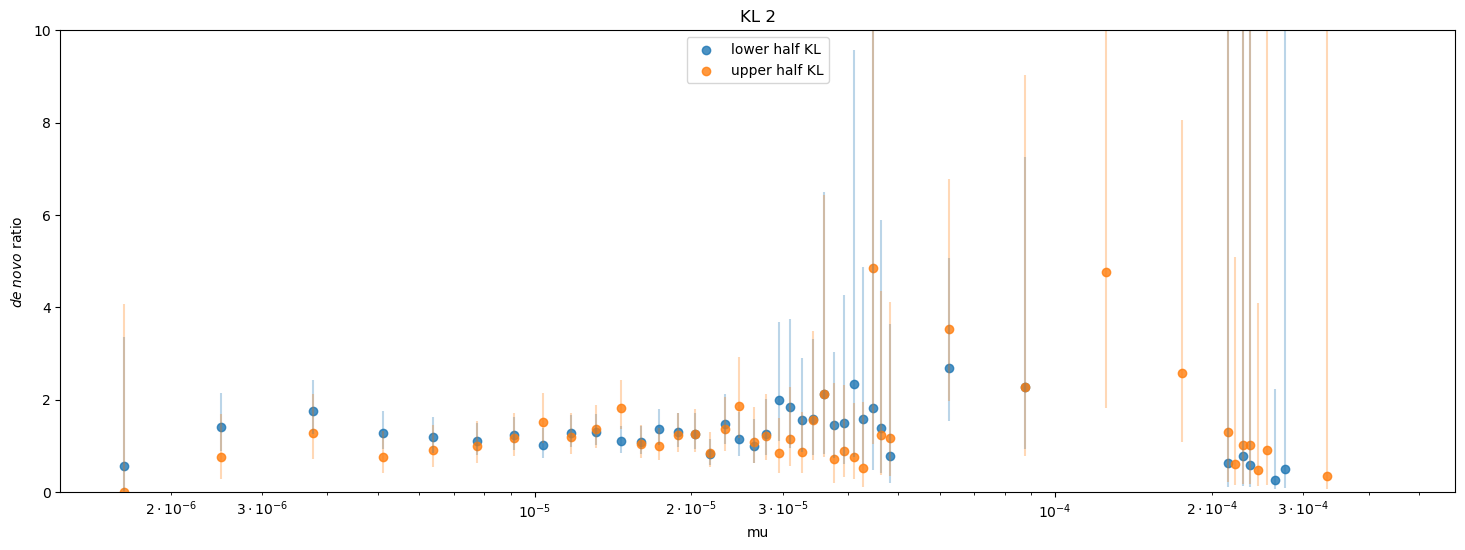

In [24]:
fig, ax = plt.subplots(figsize=(18, 6))
plot_ratios(sum, ax, mu_scale, alpha=0.8, color=c_sum, label="lower half KL")
plot_ratios(sum1, ax, mu_scale, alpha=0.8, color=c_sum1, label="upper half KL")
# plot_ratios(sum2, ax, alpha=0.8, color=c_sum2, label="AC = 2")
# plot_ratios(sum3, ax, alpha=0.8, color=c_sum3, label="AC = 3")

ax.set_xscale("logit")
ax.set_ylim([0,10])
ax.set_ylabel(r"$\it{de {}_ novo}$ ratio")
ax.set_xlabel("mu")
ax.set_title("KL 2")
ax.legend(loc="upper center")

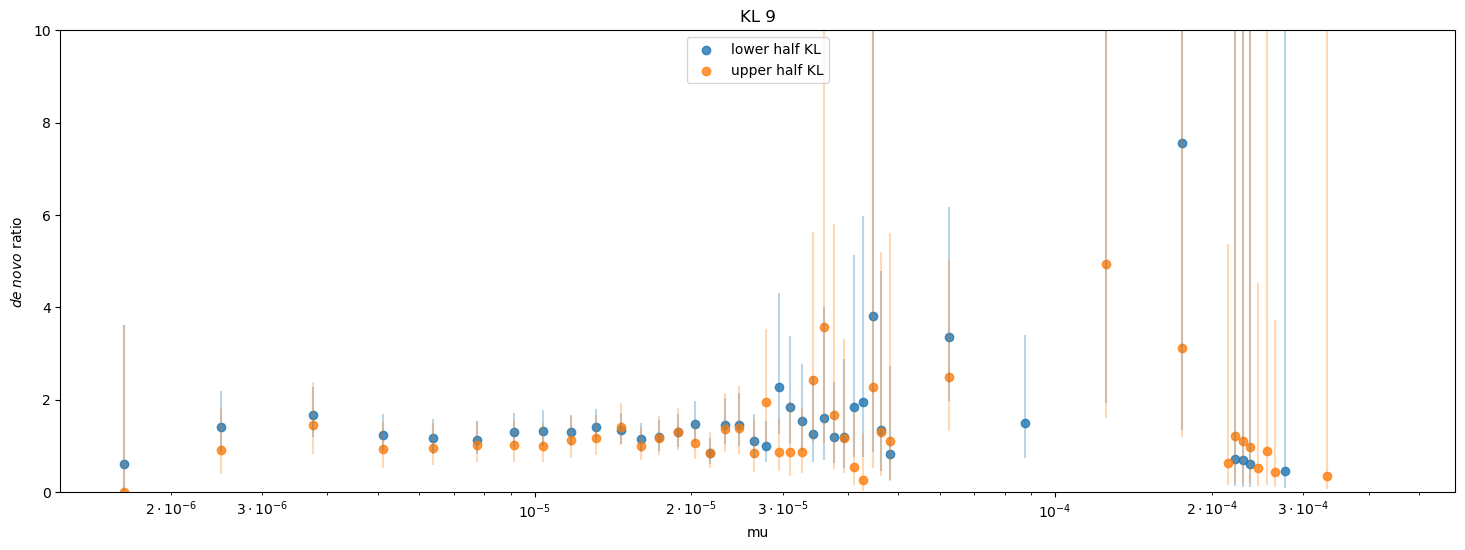

In [26]:
fig, ax = plt.subplots(figsize=(18, 6))
plot_ratios(sum2, ax, mu_scale, alpha=0.8, color=c_sum, label="lower half KL")
plot_ratios(sum3, ax, mu_scale, alpha=0.8, color=c_sum1, label="upper half KL")
# plot_ratios(sum2, ax, alpha=0.8, color=c_sum2, label="AC = 2")
# plot_ratios(sum3, ax, alpha=0.8, color=c_sum3, label="AC = 3")

ax.set_xscale("logit")
ax.set_ylim([0,10])
ax.set_ylabel(r"$\it{de {}_ novo}$ ratio")
ax.set_xlabel("mu")
ax.set_title("KL 9")
ax.legend(loc="upper center")

In [27]:
sum

,mu,number_of_mutations_SNV,number_of_sites_SNV,number_of_mutations_no_SNV,number_of_sites_no_SNV,rate_SNV_div_rate_no_SNV,total_sites,total_muts,mu_est,mu_95CI_lower,mu_95CI_upper,ratio_est,ratio_95CI_lower,ratio_95CI_upper,prop_poly
0,0.013,1.0,223748,37.0,4675227,0.564731,4898975,38.0,0.000008,0.000005,0.000011,0.564731,0.013926,3.347933,0.045672
1,0.020,24.0,1155536,227.0,15376194,1.406860,16531730,251.0,0.000015,0.000013,0.000017,1.406860,0.882995,2.146907,0.069898
2,0.030,47.0,1368922,240.0,12337675,1.764986,13706597,287.0,0.000021,0.000019,0.000024,1.764986,1.262598,2.421128,0.099873
3,0.041,49.0,1243626,252.0,8239241,1.288229,9482867,301.0,0.000032,0.000028,0.000036,1.288229,0.928547,1.755203,0.131145
4,0.051,49.0,1129913,213.0,5813307,1.183572,6943220,262.0,0.000038,0.000033,0.000043,1.183572,0.849261,1.621157,0.162736
5,0.062,54.0,1076968,203.0,4478993,1.106306,5555961,257.0,0.000046,0.000041,0.000052,1.106306,0.803790,1.500137,0.193840
6,0.073,65.0,1020739,185.0,3565401,1.227256,4586140,250.0,0.000055,0.000048,0.000062,1.227256,0.910478,1.636379,0.222570
7,0.083,55.0,973726,163.0,2913207,1.009508,3886933,218.0,0.000056,0.000049,0.000064,1.009508,0.729689,1.378243,0.250513
8,0.094,84.0,957123,171.0,2492644,1.279310,3449767,255.0,0.000074,0.000065,0.000084,1.279310,0.973287,1.670611,0.277446
9,0.105,96.0,948501,168.0,2177087,1.311596,3125588,264.0,0.000084,0.000075,0.000095,1.311596,1.009853,1.695361,0.303463
